In [1]:
# MTREND

In [5]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [6]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [7]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [8]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [9]:
bnf_pandas = pd.read_csv("../data/sensex_min (1).csv")

# INDEX = 'MIDCP'
# INDEX = 'BNF'
# INDEX = 'NIFTY'
# INDEX = 'FNF'
# INDEX = 'STOCK'
INDEX = 'SENSEX'

# lev_ = 1
INDEX_ = INDEX

if INDEX == 'BNF':
    lev_ = 6
    # lev_ = 4
    slippage_ = 0.0001
    lot_size_ = 30
    sma_ = 48
    tma_ = 18
    candles_ = 1
elif INDEX == 'NIFTY':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0002
    lot_size_ = 75
    sma_ = 32
    tma_ = 40
    candles_ = 1
elif INDEX == 'MIDCP':
    lev_ = 4.5
    # lev_ = 5
    slippage_ = 0.0005
    lot_size_ = 120
    sma_ = 9
    tma_ = 68
    candles_ = 1
elif INDEX == 'SENSEX':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0001
    lot_size_ = 20
    sma_ = 45
    tma_ = 16
    candles_ = 1
elif INDEX == 'STOCK':
    lev_ = 5
    slippage_ = 0.001
    lot_size_ = 1
# bnf_pandas = pd.read_csv("../data/finnifty_1hr_tv (2).csv")
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/finnifty_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/bnf_fut_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')


In [10]:
bnf_pandas['datetime'] = pd.to_datetime(bnf_pandas['datetime'])
bnf_pandas = bnf_pandas[bnf_pandas['datetime'].dt.time <= dt.time(15, 29)]
bnf_pandas.head()

index            datetime       open       high        low      close  \
0  sensex 2018-03-08 09:15:00 33219.5200 33292.2200 33219.5200 33286.7100   
1  sensex 2018-03-08 09:16:00 33283.4200 33306.6300 33275.7700 33306.0200   
2  sensex 2018-03-08 09:17:00 33279.8700 33279.8700 33256.5300 33258.1200   
3  sensex 2018-03-08 09:18:00 33264.2600 33288.4800 33264.2600 33282.4700   
4  sensex 2018-03-08 09:19:00 33271.1500 33271.1500 33264.9200 33266.2300   

   volume  
0       0  
1       0  
2       0  
3       0  
4       0

In [11]:
def parse_timeframe(timeframe: str) -> pl.duration:
    if timeframe.endswith('m'):
        return pl.duration(minutes=int(timeframe[:-1]))
    elif timeframe.endswith('h'):
        return pl.duration(hours=int(timeframe[:-1]))
    # Add more cases if needed
    else:
        raise ValueError(f"Unknown timeframe format: {timeframe}")

def resample(data: pl.DataFrame, timeframe: str, offset: str = '0m') -> pl.DataFrame:
    # data = data.with_columns(
    #     pl.col("datetime").str.strptime(pl.Datetime, strict=False)   # <-- fix here
    # )
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume"),
            ]
        )
    )


In [12]:
bnf = pl.DataFrame(bnf_pandas)
bnf_1hr = resample(bnf, '60m', '15m')   # offset can be '0m' if you want no offset
bnf = bnf_1hr

In [13]:
bnf.tail(100)

shape: (100, 6)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┬────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    ┆ volume │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---    │
│ datetime[ns]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ i64    │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╪════════╡
│ 2025-05-12 14:15:00 ┆ 82216.71 ┆ 82419.17 ┆ 82173.73 ┆ 82348.86 ┆ 0      │
│ 2025-05-12 15:15:00 ┆ 82349.63 ┆ 82495.97 ┆ 82330.12 ┆ 82404.81 ┆ 0      │
│ 2025-05-13 09:15:00 ┆ 82249.6  ┆ 82572.81 ┆ 81468.82 ┆ 81803.88 ┆ 0      │
│ 2025-05-13 10:15:00 ┆ 81802.79 ┆ 82101.5  ┆ 81336.04 ┆ 81692.31 ┆ 0      │
│ 2025-05-13 11:15:00 ┆ 81692.81 ┆ 81987.2  ┆ 81521.97 ┆ 81719.43 ┆ 0      │
│ 2025-05-13 12:15:00 ┆ 81719.43 ┆ 81753.45 ┆ 81170.99 ┆ 81268.84 ┆ 0      │
│ 2025-05-13 13:15:00 ┆ 81268.81 ┆ 81300.38 ┆ 81138.78 ┆ 81172.44 ┆ 0      │
│ 2025-05-13 14:15:00 ┆ 81172.92 ┆ 81324.57 ┆ 81086.26 ┆ 81096.47 ┆ 0      │
│ 2025-05-13 15:15:00 ┆ 81093.48 ┆ 81196.77 ┆ 81043.69 ┆ 81193.04 ┆ 0      │
│ 2025-05-14 09:15:00 ┆ 81278.49 ┆ 81664.2  ┆ 81184.89 ┆ 81639.91 ┆ 0      │
│ 2025-05-14 10:15:00 ┆ 81641.61 ┆ 81691.87 ┆ 81418.46 ┆ 81465.56 ┆ 0      │
│ 2025-05-14 11:15:00 ┆ 81463.96 ┆ 81526.93 ┆ 81248.24 ┆ 81379.94 ┆ 0      │
│ 2025-05-14 12:15:00 ┆ 81378.72 ┆ 81378.72 ┆ 80910.03 ┆ 81226.38 ┆ 0      │
│ 2025-05-14 13:15:00 ┆ 81225.35 ┆ 81298.93 ┆ 81080.56 ┆ 81155.05 ┆ 0      │
│ 2025-05-14 14:15:00 ┆ 81155.7  ┆ 81374.06 ┆ 81033.9  ┆ 81337.54 ┆ 0      │
│ 2025-05-14 15:15:00 ┆ 81337.77 ┆ 81441.53 ┆ 81279.65 ┆ 81414.41 ┆ 0      │
│ 2025-05-15 09:15:00 ┆ 81354.43 ┆ 81439.04 ┆ 80762.16 ┆ 80943.6  ┆ 0      │
│ 2025-05-15 10:15:00 ┆ 80940.32 ┆ 81705.54 ┆ 80859.71 ┆ 81112.87 ┆ 0      │
│ 2025-05-15 11:15:00 ┆ 81107.92 ┆ 81370.01 ┆ 81059.69 ┆ 81226.24 ┆ 0      │
│ 2025-05-15 12:15:00 ┆ 81225.64 ┆ 81983.25 ┆ 81131.83 ┆ 81977.51 ┆ 0      │
│ 2025-05-15 13:15:00 ┆ 81977.11 ┆ 82709.21 ┆ 81874.22 ┆ 82689.65 ┆ 0      │
│ 2025-05-15 14:15:00 ┆ 82691.91 ┆ 82718.14 ┆ 82486.53 ┆ 82525.42 ┆ 0      │
│ 2025-05-15 15:15:00 ┆ 82522.04 ┆ 82549.35 ┆ 82436.52 ┆ 82463.15 ┆ 0      │
│ 2025-05-16 09:15:00 ┆ 82392.63 ┆ 82514.81 ┆ 82201.49 ┆ 82293.74 ┆ 0      │
│ 2025-05-16 10:15:00 ┆ 82294.93 ┆ 82415.21 ┆ 82148.22 ┆ 82199.88 ┆ 0      │
│ 2025-05-16 11:15:00 ┆ 82200.83 ┆ 82286.36 ┆ 82146.95 ┆ 82208.97 ┆ 0      │
│ 2025-05-16 12:15:00 ┆ 82208.97 ┆ 82331.4  ┆ 82189.95 ┆ 82298.04 ┆ 0      │
│ 2025-05-16 13:15:00 ┆ 82295.55 ┆ 82390.0  ┆ 82267.45 ┆ 82337.48 ┆ 0      │
│ 2025-05-16 14:15:00 ┆ 82339.64 ┆ 82399.43 ┆ 82270.57 ┆ 82353.63 ┆ 0      │
│ 2025-05-16 15:15:00 ┆ 82353.63 ┆ 82359.5  ┆ 82263.65 ┆ 82299.5  ┆ 0      │
│ 2025-05-19 09:15:00 ┆ 82354.92 ┆ 82380.08 ┆ 82116.0  ┆ 82344.41 ┆ 0      │
│ 2025-05-19 10:15:00 ┆ 82346.78 ┆ 82424.1  ┆ 82217.1  ┆ 82312.52 ┆ 0      │
│ 2025-05-19 11:15:00 ┆ 82314.05 ┆ 82379.52 ┆ 82150.33 ┆ 82215.0  ┆ 0      │
│ 2025-05-19 12:15:00 ┆ 82196.74 ┆ 82298.89 ┆ 82157.61 ┆ 82174.68 ┆ 0      │
│ 2025-05-19 13:15:00 ┆ 82172.13 ┆ 82242.39 ┆ 81964.57 ┆ 82018.63 ┆ 0      │
│ 2025-05-19 14:15:00 ┆ 82019.37 ┆ 82100.72 ┆ 81970.84 ┆ 82070.69 ┆ 0      │
│ 2025-05-19 15:15:00 ┆ 82070.77 ┆ 82095.71 ┆ 82019.43 ┆ 82041.61 ┆ 0      │
│ 2025-05-20 09:15:00 ┆ 82116.17 ┆ 82250.42 ┆ 81804.36 ┆ 81879.4  ┆ 0      │
│ 2025-05-20 10:15:00 ┆ 81878.39 ┆ 82089.41 ┆ 81819.15 ┆ 81921.86 ┆ 0      │
│ 2025-05-20 11:15:00 ┆ 81921.68 ┆ 81921.68 ┆ 81701.41 ┆ 81725.17 ┆ 0      │
│ 2025-05-20 12:15:00 ┆ 81725.94 ┆ 81804.83 ┆ 81456.14 ┆ 81491.89 ┆ 0      │
│ 2025-05-20 13:15:00 ┆ 81492.61 ┆ 81499.74 ┆ 81314.19 ┆ 81380.64 ┆ 0      │
│ 2025-05-20 14:15:00 ┆ 81381.9  ┆ 81403.6  ┆ 81153.7  ┆ 81241.9  ┆ 0      │
│ 2025-05-20 15:15:00 ┆ 81247.21 ┆ 81302.35 ┆ 81171.97 ┆ 81272.85 ┆ 0      │
│ 2025-05-21 09:15:00 ┆ 81327.61 ┆ 81786.25 ┆ 81255.73 ┆ 81767.73 ┆ 0      │
│ 2025-05-21 10:15:00 ┆ 81769.93 ┆ 82021.64 ┆ 81769.38 ┆ 81878.35 ┆ 0      │
│ 2025-05-21 11:15:00 ┆ 81870.87 ┆ 81913.35 ┆ 81350.53 ┆ 

In [14]:
def generate_signals1(df, signal_ma, trailing_ma, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=signal_ma).mean()
    df["MA10"] = df["c"].rolling(window=trailing_ma).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = df["MA20"] > df["MA20"].shift(1)
    
    for i in range(1, candles_in_num):
        buy_signal_mask &= df["MA20"].shift(i) > df["MA20"].shift(i + 1)

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [15]:
def generate_signals2(df, i, j, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=i).mean()
    df["MA10"] = df["c"].rolling(window=j).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = df["MA20"] < df["MA20"].shift(1)

    for i in range(1, candles_in_num):
        sell_signal_mask &= df["MA20"].shift(i) < df["MA20"].shift(i + 1)

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [16]:
# # Positional

# def execute(df):

#     trade_book = []
#     in_trade = False
#     signal_entry_price = 100000
#     signal_initial_sl = 0
#     already_signal_exists = False
#     is_trailing_active = False
#     remark = ""
#     portfolio_value = 6250000
#     previous_trade_exit_time = None

#     for i in range(1, len(df)):
#         points = 0
#         current_candle_open = df.iloc[i]["o"]
#         current_candle_high = df.iloc[i]["h"]
#         current_candle_low = df.iloc[i]["l"]
#         current_candle_close = df.iloc[i]["c"]
#         current_candle_datetime = df.iloc[i]['datetime']
#         current_moving_average_price = df.iloc[i]["MA10"]

#         if not in_trade:
#             if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
#                 if not already_signal_exists:
#                     # Fresh Buy Signal
#                     # print(df.iloc[i])
#                     # print('Fresh Buy Signal')
#                     signal_entry_price = current_candle_high
#                     signal_initial_sl = current_candle_low
#                     signal_creation_time = df.iloc[i]["datetime"]
#                     already_signal_exists = True

#                     # if (signal_entry_price - signal_initial_sl > 400):
#                     #     # Skip Signal Candle Due To Big Size
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                 else:
#                     # if current_candle_open > signal_entry_price:
#                     #     # Gap Up Open, SKIP trade
#                     #     # print(df.iloc[i])
#                     #     # print('Gap Up Open, Skip Trade')
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0
                    
#                     if current_candle_high < signal_entry_price:
#                         # Better Candle
#                         # print(df.iloc[i])
#                         # print('Better Candle')
#                         signal_entry_price = current_candle_high
#                         signal_initial_sl = current_candle_low
#                         signal_creation_time = df.iloc[i]["datetime"]

#                         # if (signal_entry_price - signal_initial_sl > 400):
#                         #     # Skip Signal Candle Due To Big Size
#                         #     already_signal_exists = False
#                         #     signal_entry_price = 100000
#                         #     signal_initial_sl = 0

#                     elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         # Entry Triggered
#                         # print(df.iloc[i])
#                         # print('Entry Triggered')
#                         in_trade = True
#                         entry_time = df.iloc[i]["datetime"]
#                         entry_price = signal_entry_price
#                         points = 0
#             else:
#                 if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
#                     # Considering the forward bias condition as well now
#                     signal_entry_price = df.iloc[i - 1]["h"]
#                     signal_initial_sl = df.iloc[i - 1]["l"]
#                     signal_creation_time = df.iloc[i - 1]["datetime"]
#                     already_signal_exists = True

#                     # if current_candle_open > signal_entry_price:
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                     if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
#                             in_trade = True
#                             entry_time = df.iloc[i]["datetime"]
#                             entry_price = signal_entry_price
#                             points = 0
#                     else:
#                         # Discard Existing Signal
#                         already_signal_exists = False
#                         signal_entry_price = 100000
#                         signal_initial_sl = 0

#             # if df.iloc[i-1]["Buy_Signal"] == 1:
#             #     signal_entry_price = df.iloc[i-1]['h']
#             #     signal_initial_sl = df.iloc[i-1]['l']
#             #     signal_creation_time = df.iloc[i-1]["datetime"]

#             #     if current_candle_open > signal_entry_price:
#             #         # Gap Up Open, SKIP trade
#             #         already_signal_exists = False
#             #         signal_entry_price = 100000
#             #         signal_initial_sl = 0
                
#             #     elif current_candle_high >= signal_entry_price:
#             #         # Entry Triggered
#             #         in_trade = True
#             #         entry_time = df.iloc[i]["datetime"]
#             #         entry_price = signal_entry_price
#             #         points = 0

#         if in_trade:
#             trade_entry_price = signal_entry_price
#             trade_initial_sl = signal_initial_sl
#             trade_final_sl = signal_initial_sl

#             if (
#                 not is_trailing_active
#                 and current_candle_low > current_moving_average_price
#             ):
#                 is_trailing_active = True

#             if not is_trailing_active:
#                 if current_candle_open < trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit Before Gap Down'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # Initial SL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL Hit"

#             else:
#                 trade_final_sl = max(trade_initial_sl, current_moving_average_price)

#                 if current_candle_open <= trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # if trade_initial_sl >= current_moving_average_price:
#                     # Despite Trailing, Initial SL hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL hit"

#                 elif current_candle_close <= trade_final_sl:
#                     # Price Closed below TSL i.e. MA10 , TSL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = current_candle_close - trade_entry_price
#                     exit_price = current_candle_close
#                     exit_time = df.iloc[i]["datetime"]
#                     is_trailing_active = False
#                     remark = "TSL Hit"

#             if points:
#                 index_lev = lev_
#                 qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
#                 slippage = slippage_ * (entry_price + exit_price)
#                 # slippage = 10
#                 final_points = points - slippage
#                 # final_points = points
#                 previous_trade_exit_time = exit_time
#                 trade = {
#                     "Signal Generated At": signal_creation_time,
#                     "Trade Type": "LONG",
#                     "Entry Time": entry_time,
#                     "Entry Price": entry_price,
#                     "Initial SL": trade_initial_sl,
#                     "Final SL": trade_final_sl,
#                     "Exit Time": exit_time,
#                     "Exit Price": exit_price,
#                     "Points Captured": points,
#                     "After Costs": final_points,
#                     "PnL": final_points * qty,
#                     "Remarks": remark,
#                     "Qty": qty,
#                     "Leverage": index_lev,
#                     "ROI%": (final_points * qty / portfolio_value) * 100,
#                     "Trade Year": entry_time.year,
#                     "Trade Month": entry_time.month,
#                 }
#                 trade_book.append(trade)
#                 points = 0
#                 in_trade = False
#                 already_signal_exists = False
#                 remark = ""
#                 is_trailing_active = False

#     trade_book_df = pd.DataFrame(trade_book)
#     return trade_book_df

In [36]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 3750000
    previous_trade_exit_time = None

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_candle_datetime = df.iloc[i]['datetime']
        current_moving_average_price = df.iloc[i]["MA10"]

        if current_candle_datetime.time() == dt.time(15, 15):
            df.iloc[i]['Buy_Signal'] = 0
            # continue
        if not in_trade:
            if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                if df.iloc[i-1]['Buy_Signal'] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
                    signal_entry_price = df.iloc[i-1]['h']
                    signal_initial_sl = df.iloc[i-1]['l']
                    signal_creation_time = df.iloc[i-1]['datetime']
                    if current_candle_high >= signal_entry_price:
                        #Entry Triggered
                        entry_price = signal_entry_price
                        entry_time = current_candle_datetime
                        in_trade = True

        # if not in_trade:
        #     if current_candle_datetime.time() == dt.time(15, 15):
        #         df.iloc[i]["Buy_Signal"] = 0
        #         continue
        #     if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
        #         if not already_signal_exists:
        #             # Fresh Buy Signal
        #             # print(df.iloc[i])
        #             # print('Fresh Buy Signal')
        #             signal_entry_price = current_candle_high
        #             signal_initial_sl = current_candle_low
        #             signal_creation_time = df.iloc[i]["datetime"]
        #             already_signal_exists = True

        #             # if (signal_entry_price - signal_initial_sl > 400):
        #             #     # Skip Signal Candle Due To Big Size
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #         else:
        #             # if current_candle_open > signal_entry_price:
        #             #     # Gap Up Open, SKIP trade
        #             #     # print(df.iloc[i])
        #             #     # print('Gap Up Open, Skip Trade')
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0
                    
        #             if current_candle_high < signal_entry_price:
        #                 # Better Candle
        #                 # print(df.iloc[i])
        #                 # print('Better Candle')
        #                 signal_entry_price = current_candle_high
        #                 signal_initial_sl = current_candle_low
        #                 signal_creation_time = df.iloc[i]["datetime"]

        #                 # if (signal_entry_price - signal_initial_sl > 400):
        #                 #     # Skip Signal Candle Due To Big Size
        #                 #     already_signal_exists = False
        #                 #     signal_entry_price = 100000
        #                 #     signal_initial_sl = 0

        #             elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 # Entry Triggered
        #                 # print(df.iloc[i])
        #                 # print('Entry Triggered')
        #                 in_trade = True
        #                 entry_time = df.iloc[i]["datetime"]
        #                 entry_price = signal_entry_price
        #                 points = 0
        #     else:
        #         if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
        #             # Considering the forward bias condition as well now
        #             signal_entry_price = df.iloc[i - 1]["h"]
        #             signal_initial_sl = df.iloc[i - 1]["l"]
        #             signal_creation_time = df.iloc[i - 1]["datetime"]
        #             already_signal_exists = True

        #             # if current_candle_open > signal_entry_price:
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #             if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
        #                     in_trade = True
        #                     entry_time = df.iloc[i]["datetime"]
        #                     entry_price = signal_entry_price
        #                     points = 0
        #             else:
        #                 # Discard Existing Signal
        #                 already_signal_exists = False
        #                 signal_entry_price = 100000
        #                signal_initial_sl = 0

            # if df.iloc[i-1]["Buy_Signal"] == 1:
            #     signal_entry_price = df.iloc[i-1]['h']
            #     signal_initial_sl = df.iloc[i-1]['l']
            #     signal_creation_time = df.iloc[i-1]["datetime"]

            #     if current_candle_open > signal_entry_price:
            #         # Gap Up Open, SKIP trade
            #         already_signal_exists = False
            #         signal_entry_price = 100000
            #         signal_initial_sl = 0
                
            #     elif current_candle_high >= signal_entry_price:
            #         # Entry Triggered
            #         in_trade = True
            #         entry_time = df.iloc[i]["datetime"]
            #         entry_price = signal_entry_price
            #         points = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                index_lev = lev_
                qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": index_lev,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False
                i += 1

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [37]:
bnf1 = bnf
bnf2 = bnf

In [38]:
def generate_stats(tb_expiry, signal_ma, trailing_ma):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f'{signal_ma} , {trailing_ma}'
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [39]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()

In [40]:
bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
bnf2['datetime'] = pd.to_datetime(bnf2['datetime'])

In [41]:
bnf1 = bnf1[bnf1['datetime'].dt.time >= dt.time(9, 14)]
bnf1 = bnf2[bnf2['datetime'].dt.time >= dt.time(9, 14)]

In [42]:
bnf1.tail(15000)

datetime       open       high        low      close  volume
0     2018-03-08 09:15:00 33219.5200 33306.6300 33219.5200 33249.9500       0
1     2018-03-09 09:15:00 33469.7200 33476.9400 33379.8600 33389.5700       0
2     2018-03-09 11:15:00 33394.0700 33486.0700 33393.8900 33459.0700       0
3     2018-03-09 12:15:00 33459.5900 33490.8200 33443.9000 33474.3000       0
4     2018-03-13 12:15:00 34010.9200 34068.3000 33991.0800 34030.2400       0
5     2018-03-13 13:15:00 34029.9600 34045.6700 33736.6700 33772.4500       0
6     2018-03-13 14:15:00 33772.4500 33941.8700 33722.9600 33816.8700       0
7     2018-03-13 15:15:00 33813.4000 33874.1000 33811.7400 33842.0700       0
8     2018-03-14 09:15:00 33746.3200 33799.1100 33690.8900 33729.7000       0
9     2018-03-14 10:15:00 33729.4700 33763.5400 33683.9000 33702.8900       0
10    2018-03-14 11:15:00 33702.9900 33708.3900 33619.0500 33633.7900       0
11    2018-03-14 12:15:00 33633.7900 33710.9800 33580.6900 33667.4500       0
12    2018-03-14 13:15:00 33666.3000 33759.2100 33665.6900 33697.6100       0
13    2018-03-14 14:15:00 33697.5500 33853.7800 33667.1600 33821.3500       0
14    2018-03-14 15:15:00 33820.2700 33875.1500 33820.0600 33860.8600       0
15    2018-03-15 09:15:00 33839.8900 33863.8100 33769.5400 33844.0700       0
16    2018-03-15 10:15:00 33844.2100 33866.1600 33759.4100 33759.4100       0
17    2018-03-15 11:15:00 33759.4100 33773.7000 33733.5000 33761.7100       0
18    2018-03-15 12:15:00 33761.7100 33822.0700 33761.2700 33822.0700       0
19    2018-03-15 13:15:00 33822.2200 33835.3000 33678.0000 33703.9200       0
20    2018-03-15 14:15:00 33703.7400 33774.6400 33677.3800 33697.1600       0
21    2018-03-15 15:15:00 33698.0100 33707.0200 33637.2800 33656.8100       0
22    2018-03-16 09:15:00 33686.4900 33686.4900 33494.2600 33498.8200       0
23    2018-03-16 10:15:00 33498.8200 33521.0700 33466.0000 33491.2100       0
24    2018-03-16 11:15:00 33491.2600 33501.5500 33397.1100 33407.5600       0
25    2018-03-16 12:15:00 33406.4800 33423.9400 33366.9000 33388.6900       0
26    2018-03-16 13:15:00 33388.5100 33423.9300 33271.8900 33278.8500       0
27    2018-03-16 14:15:00 33279.4200 33303.4000 33120.3000 33152.8900       0
28    2018-03-16 15:15:00 33153.0200 33259.7600 33152.9700 33253.3500       0
29    2018-03-19 09:15:00 33258.8300 33258.8300 33089.2700 33129.2200       0
30    2018-03-19 10:15:00 33128.2900 33143.0400 33071.2000 33109.7200       0
31    2018-03-19 11:15:00 33109.7200 33134.6400 33042.3600 33082.5900       0
32    2018-03-19 12:15:00 33082.5900 33085.8800 32950.2600 32978.3000       0
33    2018-03-19 13:15:00 32978.3000 33030.2600 32906.4300 32943.8600       0
34    2018-03-19 14:15:00 32943.8600 33041.2500 32856.6700 32894.7600       0
35    2018-03-19 15:15:00 32897.3600 32940.6200 32889.6500 32919.2400       0
36    2018-03-20 09:15:00 32812.4600 33019.5000 32812.4600 33006.1700       0
37    2018-03-20 10:15:00 33005.5100 33043.7800 32975.0000 32993.8300       0
38    2018-03-20 11:15:00 32993.6400 33101.9000 32993.6400 33087.5100       0
39    2018-03-20 12:15:00 33087.5100 33091.3200 33002.0200 33019.8400       0
40    2018-03-20 13:15:00 33019.1900 33054.8600 32931.0400 32987.3100       0
41    2018-03-20 14:15:00 32987.3100 33045.1800 32909.9700 32990.7200       0
42    2018-03-20 15:15:00 32990.3900 33046.6800 32975.0600 33046.6800       0
43    2018-03-21 09:15:00 33181.4000 33329.6700 33176.0300 33310.6700       0
44    2018-03-21 10:15:00 33311.1100 33354.7700 33309.2800 33350.6600       0
45    2018-03-21 11:15:00 33349.8400 33352.6500 33197.4500 33240.9600       0
46    2018-03-21 12:15:00 33241.7200 33246.2900 33160.1100 33179.1100       0
47    2018-03-21 13:15:00 33178.8300 33269.9900 33126.8600 33136.1000       0
48    2018-03-21 14:15:00 33133.3900 33184.8600 33070.8700 33151.9200       0
49    2018-03-21 15:15:00 33151.8000 33155.7600 33119.1800 33146.3200       0
50    2018-03-22 09:15:00 33196.4700 33

In [43]:
# stats_dictionary = {}

# for i in range(6, 81):
#     for j in range(4, 101, 2):
#         print(f"Signal MA : {i} , Trailing MA : {j}")
#         signals_df1 = generate_signals1(bnf1, i, j)
#         signals_df1 = signals_df1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#         new_tb = execute(signals_df1)
#         new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
#         tradebook_buy_side = new_tb
#         stats = generate_stats(tradebook_buy_side, i, j)
#         for overall_roi_dd_ratio, stats_df in stats.items():
#             if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
#                 print(stats_df.to_string())
#                 stats_dictionary[overall_roi_dd_ratio] = stats_df

In [44]:
# sorted_stats = {k: v for k, v in sorted(stats_dictionary.items(), key=lambda item: item[0], reverse=True)}
# sorted_stats

In [45]:
bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [46]:
sma = 45
tma = 14
candles = 1
variation = f'{INDEX}, {sma} , {tma} , {candles}'
signals_df1 = generate_signals1(bnf1, sma, tma, candles)

In [47]:
# signals_df2.tail(130)

In [48]:

new_tb = execute(signals_df1)
# new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

/tmp/ipykernel_15849/3715834428.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i]['Buy_Signal'] = 0


In [49]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [50]:
# new_tb.tail(50)
new_tb[new_tb['Entry Time'].dt.time == dt.time(9, 15)]

Signal Generated At Trade Type          Entry Time  Entry Price  \
76 2019-01-22 12:15:00       LONG 2019-01-23 09:15:00   36317.2100   
77 2019-02-01 09:15:00       LONG 2019-02-04 09:15:00   36311.7400   

    Initial SL   Final SL           Exit Time  Exit Price  Points Captured  \
76  36300.0500 36300.0500 2019-01-24 09:15:00  36146.5500        -170.6600   
77  36311.7400 36975.1271 2019-02-07 15:15:00  36930.8800         619.1400   

    After Costs          PnL               Remarks  Qty  Leverage    ROI%  \
76    -177.9064 -138766.9733  Gap Open Outside ISL  780    7.5000 -3.7005   
77     611.8157  477216.2756               TSL Hit  780    7.5000 12.7258   

    Trade Year  Trade Month  
76        2019            1  
77        2019            2

In [51]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    
    # print(f'{overall_total_roi} , {overall_max_drawdown} , {overall_roi_dd_ratio}')
    
    return {overall_roi_dd_ratio: stats_df8}

In [52]:
final_stats = None
stats = generate_stats(tradebook_buy_side, variation)
for x, y in stats.items():
    final_stats = y

final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2017       0.0000            0      NaN                   NaN   
2018      95.2762           67  41.7910                5.6813   
2019      83.9135           90  28.8889                9.1721   
2020     266.3691           85  34.1176               15.0723   
2021     142.9351           95  34.7368                9.1503   
2022      80.5740           94  34.0426                7.7890   
2023     122.2522           92  30.4348                8.7110   
2024      43.3827           85  30.5882                6.9269   
2025      39.4701           37  27.0270               10.5418   
Overall  874.1728          645  32.8682                9.0343   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio            Variation  
2017                    NaN          NaN          NaN  SENSEX, 45 , 14 , 1  
2018                -1.6359     -10.2581       9.2879  SENSEX, 45 , 14 , 1  
2019                -2.4150     -21.7209       3.8633  SENSEX, 45 , 14 , 1  
2020                -3.0487     -34.2235       7.7832  SENSEX, 45 , 14 , 1  
2021                -2.5649     -33.3234       4.2893  SENSEX, 45 , 14 , 1  
2022                -2.7205     -27.3142       2.9499  SENSEX, 45 , 14 , 1  
2023                -1.9009     -26.0528       4.6925  SENSEX, 45 , 14 , 1  
2024                -2.3172     -25.8556       1.6779  SENSEX, 45 , 14 , 1  
2025                -2.4425     -16.6330       2.3730  SENSEX, 45 , 14 , 1  
Overall             -2.4044     -36.9162      23.6799  SENSEX, 45 , 14 , 1

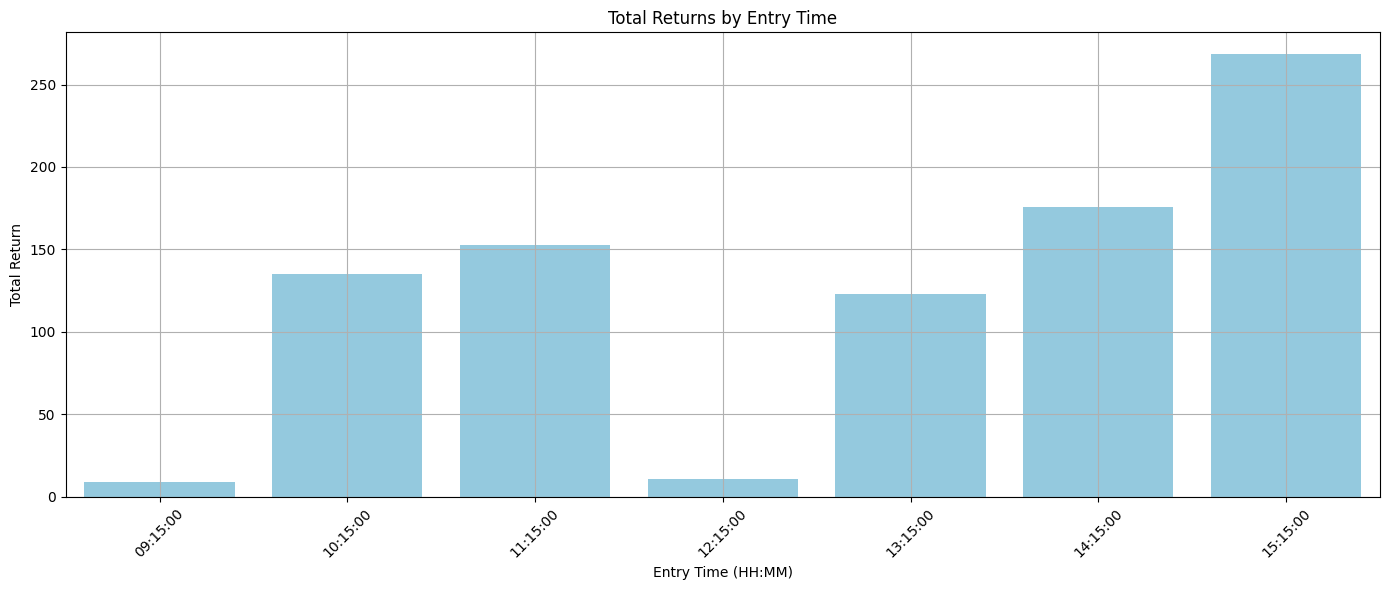

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tradebook_buy_side.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['Entry Time'].dt.time.apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
tradebook_buy_side.to_csv(f'{INDEX_}_mtrend.csv', index=False)

In [57]:
# bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [259]:
stats_dict = {}

for i in range(41, 50):
    for j in range(11, 20):
            variation = f'SMA: {i}, TMA: {j}'
            print(variation)
            signals_df1 = generate_signals1(bnf1, i, j, 1)
            new_tb = execute(signals_df1)
            stats = generate_stats(new_tb, variation)
            for overall_roi_dd_ratio, stats_df in stats.items():
                if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 15:
                    stats_dict[overall_roi_dd_ratio] = stats_df
                    print(stats_df.to_string())

SMA: 41, TMA: 11
SMA: 41, TMA: 12
SMA: 41, TMA: 13
SMA: 41, TMA: 14
SMA: 41, TMA: 15
SMA: 41, TMA: 16
SMA: 41, TMA: 17
SMA: 41, TMA: 18
SMA: 41, TMA: 19
SMA: 42, TMA: 11
SMA: 42, TMA: 12
SMA: 42, TMA: 13
SMA: 42, TMA: 14
SMA: 42, TMA: 15
SMA: 42, TMA: 16
SMA: 42, TMA: 17
SMA: 42, TMA: 18
SMA: 42, TMA: 19
SMA: 43, TMA: 11
SMA: 43, TMA: 12
SMA: 43, TMA: 13
SMA: 43, TMA: 14
SMA: 43, TMA: 15
SMA: 43, TMA: 16
SMA: 43, TMA: 17
SMA: 43, TMA: 18
SMA: 43, TMA: 19
SMA: 44, TMA: 11
SMA: 44, TMA: 12
SMA: 44, TMA: 13
SMA: 44, TMA: 14
SMA: 44, TMA: 15
SMA: 44, TMA: 16
SMA: 44, TMA: 17
SMA: 44, TMA: 18
SMA: 44, TMA: 19
SMA: 45, TMA: 11
        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation
2019      84.2888           98  28.5714                8.6608             -2.2602     -22.4306       3.7578  SMA: 45, TMA: 11
2020     214.1564           93  32.2581               13.8710             -3.2059     -34.2640       6.2502  SMA: 45, T

In [260]:
sorted_stats = {k: v for k, v in sorted(stats_dict.items(), key=lambda item: item[0], reverse=True)}

In [261]:
sorted_stats

{20.651903346447934:         Total ROI Total Trades Win Rate Avg Profit% per Trade  \
 2019      75.3356           90  28.8889                8.7580   
 2020     270.9227           83  34.9398               15.0935   
 2021     138.8885           93  35.4839                8.9262   
 2022      89.2523           93  34.4086                7.8499   
 2023     121.6089           91  30.7692                8.6523   
 2024      42.9116           85  30.5882                6.9048   
 2025      25.7974           18  33.3333               10.4710   
 Overall  764.7171          553  33.2263                8.9355   
 
         Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation  
 2019                -2.3808     -21.8304       3.4509  SMA: 45, TMA: 14  
 2020                -3.0887     -34.1072       7.9433  SMA: 45, TMA: 14  
 2021                -2.5946     -36.3802       3.8177  SMA: 45, TMA: 14  
 2022                -2.6548     -27.0991       3.2936  SMA: 45, TMA: 14  
 2023    

# MTrend BNF

In [36]:
# new_tb.to_csv('BNF Mtrend New.csv', index=False)

In [139]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 7500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False
    previous_trade_exit_time = None

    print(lev_, slippage_, portfolio_value)
    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    # print(df.iloc[i])
                    # print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        # print('Signal Entry Price' , signal_entry_price)
                        # print(df.iloc[i])
                        # print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                            in_trade = True
                            entry_time = df.iloc[i]["datetime"]
                            entry_price = signal_entry_price
                            points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round((portfolio_value * lev_ / entry_price) / lot_size_) * lot_size_)
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": lev_,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                # print(trade)
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [38]:
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv_new.csv')

In [39]:
# bnf_pandas.head()

In [40]:
# # If Stocks Data ...
# bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["time"])
# bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
# bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# # bnf_pandas

In [41]:
# bnf = pl.DataFrame(bnf_pandas)
# bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")


In [42]:
# data = pl.DataFrame(data)
# data = data.with_columns([
#     pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
# ])

In [140]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2022, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2022, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [44]:
# targets = [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 100]
# time_frames = ["3m", "5m", "10m", "15m", "30m", "60m"]
# num_candles = [1, 2, 3, 4, 5]
# for i in range(5, 81, 5):
#     for j in range(5, 81, 5):
#         for k in targets:
#             for tf in time_frames:
#                 for candles in num_candles:
#                     if tf == "10m":
#                         offset = "5m"
#                     elif tf == "30m" or tf == "60m":
#                         offset = "15m"
#                     else:
#                         offset = "0m"
#                     variation = f"SMA: {i}, TMA: {j}, Target: {k}R, TF: {tf}, Candles: {candles}"
#                     print(variation)
#                     data_w_signals = (resample(data, tf, offset)).to_pandas()
#                     data_w_signals = generate_signals2(data_w_signals, i, j, candles)
#                     data_w_signals2 = data_w_signals.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#                     sell_tb = execute_sell_side(data_w_signals2)
#                     stats = generate_stats(sell_tb, variation)
#                     for overall_roi_dd_ratio, stats_df in stats.items():
#                         if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 3:
#                             print(stats_df.to_string())
#                             stats_dictionary[overall_roi_dd_ratio] = stats_df

In [ ]:
# tradebook_sell_side

In [45]:
# bnf_pandas.head()

In [180]:
signals_df1 = generate_signals2(bnf1, 50, 49, 5)
tradebook_sell_side = execute_sell_side(signals_df1)

3 0.0005 7500000


In [182]:
# tradebook_sell_side = tradebook_sell_side[154:]
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
1  2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
2  2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
3  2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
4  2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
5  2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
6  2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
7  2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
8  2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
9  2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
10 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
11 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
12 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
13 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
14 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
15 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
16 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
17 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
18 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
19 2022-10-18 10:15:00      SHORT 2022-10-18 11:15:00    7317.2000   
20 2022-11-11 09:15:00      SHORT 2022-11-11 10:15:00    7369.2000   
21 2022-11-23 12:15:00      SHORT 2022-11-23 13:15:00    7254.5500   
22 2022-11-24 11:15:00      SHORT 2022-11-24 12:15:00    7263.7500   
23 2022-12-12 15:15:00      SHORT 2022-12-13 09:15:00    7411.0000   
24 2022-12-13 13:15:00      SHORT 2022-12-13 14:15:00    7405.5500   
25 2022-12-16 12:15:00      SHORT 2022-12-16 13:15:00    7321.4500   
26 2022-12-21 11:15:00      SHORT 2022-12-21 12:15:00    7352.5500   
27 2022-12-28 11:15:00      SHORT 2022-12-28 12:15:00    7158.1000   
28 2022-12-30 10:15:00      SHORT 2022-12-30 11:15:00    7195.4000   
29 2022-12-30 13:15:00      SHORT 2022-12-30 14:15:00    7191.4500   
30 2023-01-10 15:15:00      SHORT 2023-01-11 09:15:00    7129.9000   
31 2023-01-11 10:15:00      SHORT 2023-01-11 11:15:00    7127.7500   
32 2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
33 2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
34 2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
35 2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
36 2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
37 2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
38 2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
39 2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
40 2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
41 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
42 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
43 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
44 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
45 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
46 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
47 2023-09-22 09:15:00      SHORT 2023-09-28 14:15:00    9030.2000   
48 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
49 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
50 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
51 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
52 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
53 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
54 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
55 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
56 2024-01-24

In [177]:
st = generate_stats(tradebook_sell_side, '///')

In [178]:
final_stats = pd.DataFrame()
for x, y in st.items():
    final_stats = pd.DataFrame(y)

In [166]:
final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2022       0.0000            0      NaN                   NaN   
2023       0.0000            0      NaN                   NaN   
2024     -33.9828           27   7.4074                1.3250   
Overall  -33.9828           27   7.4074                1.3250   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
2022                    NaN          NaN          NaN       ///  
2023                    NaN          NaN          NaN       ///  
2024                -1.4653     -33.1398      -1.0254       ///  
Overall             -1.4653     -33.1398      -1.0254       ///

# Stats from May 2024 to Oct 2024

In [179]:
final_stats

Total ROI Total Trades Win Rate Avg Profit% per Trade  \
2022      79.8412           30  36.6667                9.7085   
2023       6.4825           23  30.4348                3.6107   
2024     -15.5394           21   9.5238                4.7988   
Overall   70.7843           74  27.0270                7.0833   

        Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation  
2022                -1.4186      -6.4194      12.4374       ///  
2023                -1.1745      -6.7692       0.9576       ///  
2024                -1.3230     -14.0853      -1.1032       ///  
Overall             -1.3126     -16.5891       4.2669       ///

# Initial Stats till May 2024

In [176]:
tradebook_sell_side = tradebook_sell_side[:74]
# tradebook_sell_side

In [183]:
tradebook_sell_side

Signal Generated At Trade Type          Entry Time  Entry Price  \
0  2022-01-21 10:15:00      SHORT 2022-01-21 11:15:00    7616.7500   
1  2022-01-28 11:15:00      SHORT 2022-01-28 12:15:00    7548.7000   
2  2022-01-31 13:15:00      SHORT 2022-01-31 14:15:00    7514.1500   
3  2022-02-01 10:15:00      SHORT 2022-02-01 11:15:00    7560.3500   
4  2022-02-09 15:15:00      SHORT 2022-02-10 09:15:00    7505.7000   
5  2022-02-10 12:15:00      SHORT 2022-02-10 13:15:00    7548.0500   
6  2022-03-03 11:15:00      SHORT 2022-03-03 12:15:00    6978.0500   
7  2022-03-11 12:15:00      SHORT 2022-03-11 13:15:00    6885.2000   
8  2022-03-11 15:15:00      SHORT 2022-03-14 09:15:00    6930.3500   
9  2022-04-19 11:15:00      SHORT 2022-04-19 12:15:00    7451.6500   
10 2022-04-29 14:15:00      SHORT 2022-04-29 15:15:00    7225.3500   
11 2022-05-18 10:15:00      SHORT 2022-05-18 11:15:00    6743.3000   
12 2022-05-27 09:15:00      SHORT 2022-05-27 10:15:00    6617.8500   
13 2022-06-10 10:15:00      SHORT 2022-06-10 11:15:00    6635.7000   
14 2022-08-29 13:15:00      SHORT 2022-08-29 14:15:00    7257.1500   
15 2022-08-30 11:15:00      SHORT 2022-08-30 12:15:00    7371.0000   
16 2022-09-19 10:15:00      SHORT 2022-09-19 11:15:00    7395.0000   
17 2022-09-20 10:15:00      SHORT 2022-09-20 11:15:00    7537.4000   
18 2022-09-30 15:15:00      SHORT 2022-10-03 09:15:00    7195.2000   
19 2022-10-18 10:15:00      SHORT 2022-10-18 11:15:00    7317.2000   
20 2022-11-11 09:15:00      SHORT 2022-11-11 10:15:00    7369.2000   
21 2022-11-23 12:15:00      SHORT 2022-11-23 13:15:00    7254.5500   
22 2022-11-24 11:15:00      SHORT 2022-11-24 12:15:00    7263.7500   
23 2022-12-12 15:15:00      SHORT 2022-12-13 09:15:00    7411.0000   
24 2022-12-13 13:15:00      SHORT 2022-12-13 14:15:00    7405.5500   
25 2022-12-16 12:15:00      SHORT 2022-12-16 13:15:00    7321.4500   
26 2022-12-21 11:15:00      SHORT 2022-12-21 12:15:00    7352.5500   
27 2022-12-28 11:15:00      SHORT 2022-12-28 12:15:00    7158.1000   
28 2022-12-30 10:15:00      SHORT 2022-12-30 11:15:00    7195.4000   
29 2022-12-30 13:15:00      SHORT 2022-12-30 14:15:00    7191.4500   
30 2023-01-10 15:15:00      SHORT 2023-01-11 09:15:00    7129.9000   
31 2023-01-11 10:15:00      SHORT 2023-01-11 11:15:00    7127.7500   
32 2023-01-23 13:15:00      SHORT 2023-01-23 14:15:00    7039.0000   
33 2023-01-24 09:15:00      SHORT 2023-01-24 10:15:00    7040.0000   
34 2023-02-02 11:15:00      SHORT 2023-02-02 12:15:00    6916.4000   
35 2023-02-02 15:15:00      SHORT 2023-02-03 09:15:00    6935.0500   
36 2023-02-03 15:15:00      SHORT 2023-02-06 09:15:00    6946.3500   
37 2023-02-20 12:15:00      SHORT 2023-02-20 13:15:00    7016.1000   
38 2023-02-20 14:15:00      SHORT 2023-02-20 15:15:00    6998.9500   
39 2023-02-21 11:15:00      SHORT 2023-02-21 12:15:00    7002.6500   
40 2023-03-01 15:15:00      SHORT 2023-03-02 09:15:00    6870.0500   
41 2023-03-02 11:15:00      SHORT 2023-03-02 12:15:00    6878.0500   
42 2023-03-13 15:15:00      SHORT 2023-03-14 09:15:00    6764.9500   
43 2023-03-15 11:15:00      SHORT 2023-03-15 12:15:00    6770.1500   
44 2023-03-17 09:15:00      SHORT 2023-03-17 10:15:00    6816.6500   
45 2023-03-22 12:15:00      SHORT 2023-03-22 13:15:00    6812.0000   
46 2023-09-21 15:15:00      SHORT 2023-09-22 09:15:00    9067.1500   
47 2023-09-22 09:15:00      SHORT 2023-09-28 14:15:00    9030.2000   
48 2023-09-29 13:15:00      SHORT 2023-09-29 14:15:00    9112.7500   
49 2023-10-09 11:15:00      SHORT 2023-10-09 12:15:00    9019.2500   
50 2023-10-09 14:15:00      SHORT 2023-10-09 15:15:00    9019.6500   
51 2023-10-19 14:15:00      SHORT 2023-10-19 15:15:00    9058.8000   
52 2023-11-02 10:15:00      SHORT 2023-11-02 11:15:00    8814.0000   
53 2024-01-18 13:15:00      SHORT 2024-01-18 14:15:00   10403.4500   
54 2024-01-23 15:15:00      SHORT 2024-01-24 09:15:00   10333.6000   
55 2024-01-24 10:15:00      SHORT 2024-01-24 11:15:00   10444.4000   
56 2024-01-24

In [184]:
tradebook_sell_side.to_csv('All midcp short trades MTREND.csv')